# XGBoost Classifier

In [23]:
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import xgboost as xgb
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, cross_validate
# Custom functions:
from src.printCVresults import print_results_cross_validate as print_cv_results
from src.CmROCprint import plot_roc_cm
# Interpretation 
import shap
# print the JS visualization code to the notebook
shap.initjs()
SEED=0

In [2]:
data=pd.read_csv('data/input.data.csv')
print(data.shape)
data.head()

(50847, 22)


,cell,gene,log2_fpkm,tss_pc_distance,locus_locus_distance,transcript_length,number_of_exons,is_intergenic,is_antisense,near_vista_enhancer,...,near_hnisz_super_enhancer,near_cancer_associated_snp,within_pol2_loop,within_ctcf_loop,has_mouse_ortholog,locus_is_amplified,locus_is_heterozygous_deleted,locus_is_homozygous_deleted,locus_is_normal,hit
0,K562,LH00001,2.9612,48473,43833,3019.5,2.5,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,K562,LH00002,-0.1795,44966,42685,609.0,2.0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,K562,LH00004,-1.3535,22062,0,582.0,2.0,1,0,0,...,0,1,0,0,1,0,0,0,1,0
3,K562,LH00005,-1.0786,7516,0,639.0,4.0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,K562,LH00006,-3.3219,93681,92687,295.0,2.0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [7]:
# Arrange features
cols= ['log2_fpkm', 'near_fantom_enhancer', 'near_cancer_associated_snp', 'number_of_exons',
      'within_pol2_loop', 'near_hnisz_super_enhancer', 'within_ctcf_loop', 'near_hnisz_enhancer',
      'has_mouse_ortholog', 'locus_is_heterozygous_deleted', 'is_intergenic', 'transcript_length',
      'locus_is_amplified', 'is_antisense', 'locus_locus_distance', 'tss_pc_distance', 'near_vista_enhancer',
      'locus_is_homozygous_deleted']

X= data[cols].copy()
X.head()

,log2_fpkm,near_fantom_enhancer,near_cancer_associated_snp,number_of_exons,within_pol2_loop,near_hnisz_super_enhancer,within_ctcf_loop,near_hnisz_enhancer,has_mouse_ortholog,locus_is_heterozygous_deleted,is_intergenic,transcript_length,locus_is_amplified,is_antisense,locus_locus_distance,tss_pc_distance,near_vista_enhancer,locus_is_homozygous_deleted
0,2.9612,0,0,2.5,0,0,0,0,0,0,1,3019.5,0,0,43833,48473,0,0
1,-0.1795,0,0,2.0,0,0,0,0,0,0,1,609.0,0,0,42685,44966,0,0
2,-1.3535,0,1,2.0,0,0,0,0,1,0,1,582.0,0,0,0,22062,0,0
3,-1.0786,0,0,4.0,0,0,0,0,0,0,1,639.0,0,0,0,7516,0,0
4,-3.3219,0,0,2.0,0,0,0,0,0,0,1,295.0,0,0,92687,93681,0,0


In [4]:
y= data[['hit']].copy()
num_classses= Counter(y.values.ravel())
print(num_classses)
print( np.round( (sum(y.values)/len(y.values))*100 ,2))
y.head()

Counter({0: 49936, 1: 911})
[1.79]


,hit
0,0
1,0
2,0
3,0
4,0


In [9]:
X.dtypes

log2_fpkm                        float64
near_fantom_enhancer               int64
near_cancer_associated_snp         int64
number_of_exons                  float64
within_pol2_loop                   int64
near_hnisz_super_enhancer          int64
within_ctcf_loop                   int64
near_hnisz_enhancer                int64
has_mouse_ortholog                 int64
locus_is_heterozygous_deleted      int64
is_intergenic                      int64
transcript_length                float64
locus_is_amplified                 int64
is_antisense                       int64
locus_locus_distance               int64
tss_pc_distance                    int64
near_vista_enhancer                int64
locus_is_homozygous_deleted        int64
dtype: object

In [10]:
Counter(X.dtypes)

Counter({dtype('float64'): 3, dtype('int64'): 15})

In [6]:
y.dtypes

hit    int64
dtype: object

## Training XGBoost model
### It took 22 minutes to train using RTX2060 mobile GPU
* 1) **max_depth**: the max tree depth
* 2) **learning rate**: eta
* 3) **gamma**: tree complexity parameter used for pruning
* 4) **reg_lambda**: regularization parameter for similarity score, cover and output value
* 5) **scale_pos_weight**: helps for imbalanced data   

In [14]:
# CV:
stratified_cv= RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state= SEED)

scoring = {'sensitivity': 'recall', 'f1_score': 'f1', 'precision': 'precision',
          'auroc': 'roc_auc'}

{'gamma': 1.0, 'learning_rate': 0.05, 'max_depth': 5, 'reg_lambda': 5.0, 'scale_pos_weight': 100, 'tree_method': 'gpu_hist', 'objective': 'binary:logistic', 'use_label_encoder': False, 'missing': None, 'seed': 0, 'eval_metric': ['auc']}
----------
XGBClassifier mean sensitivity: 0.7618 (+/- 0.0365)
XGBClassifier mean f1_score: 0.1071 (+/- 0.0048)
XGBClassifier mean precision: 0.0576 (+/- 0.0026)
XGBClassifier mean auroc: 0.8195 (+/- 0.0205)
----------


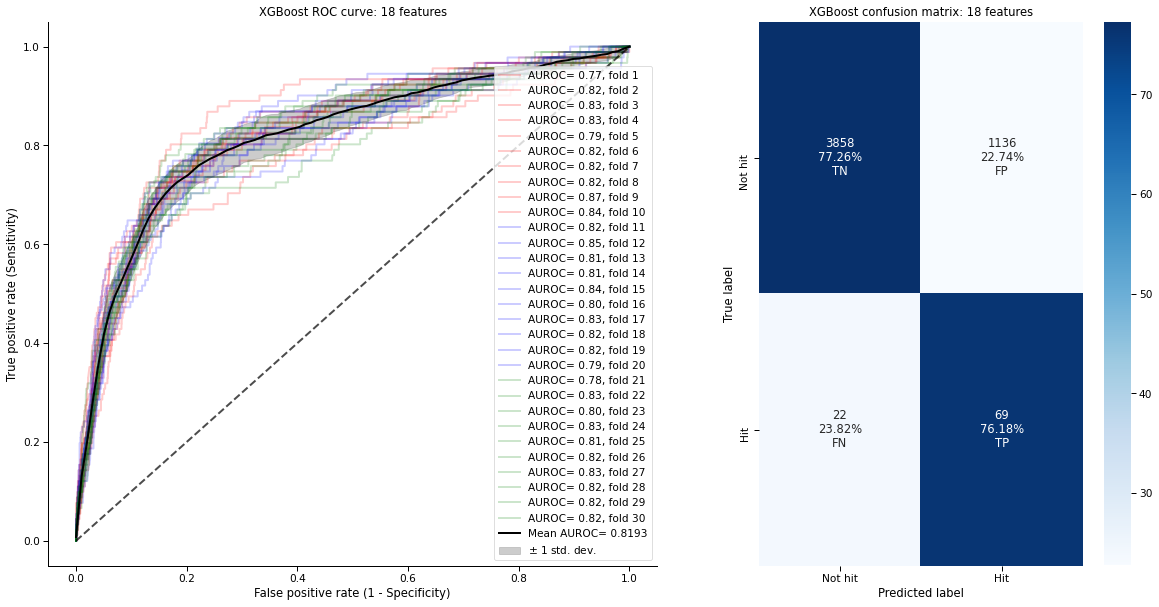

CPU times: user 39.7 s, sys: 265 ms, total: 39.9 s
Wall time: 19.1 s


In [22]:
%%time

gamma= 1.0; learning_rate= 0.05; max_depth=5; reg_lambda= 5.0; scale_pos_weight=100 #TEST: TN= 82.24; TP= 72.45 ; ALL DATA: TN= 82.14; TP= 84.74

gs_results= dict(gamma= gamma, 
                 learning_rate= learning_rate,
                 max_depth= max_depth, 
                 reg_lambda= reg_lambda, 
                 scale_pos_weight= scale_pos_weight,
                 tree_method= 'gpu_hist',
                 objective= 'binary:logistic', use_label_encoder= False, missing= None, seed= SEED, eval_metric= ['auc'])

print(gs_results)

# Model:
model= xgb.XGBClassifier(**gs_results)

### CV results: 
results= cross_validate(model, X, y.values.ravel(), cv= stratified_cv, scoring= list(scoring.values()), return_train_score= False, verbose=0)
print_cv_results(scoring, model, results)


### Plotting: 
sns.set_context("paper", 1.2)
plot_roc_cm(model= model, cv= stratified_cv, X=X, y=y, verbose=False, 
            roc_title= f'XGBoost ROC curve: {X.shape[1]} features', cm_title= f'XGBoost confusion matrix: {X.shape[1]} features')

## Save model

In [26]:
model_name= 'model/xgb.classifier.pkl'
pickle.dump(model, open(model_name, "wb"))